For point (-117.78, 33.95) found 525 Pl@ntNet dates and 291 iNaturalist dates. Total: 816.


/opt/anaconda3/envs/bloom/lib/python3.10/site-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


For point (-119.84, 35.15) found 40 Pl@ntNet dates and 98 iNaturalist dates. Total: 138.
For point (-118.38, 34.72) found 299 Pl@ntNet dates and 71 iNaturalist dates. Total: 370.
For point (-120.45, 34.51) found 47 Pl@ntNet dates and 28 iNaturalist dates. Total: 75.
For point (-120.03, 34.71) found 68 Pl@ntNet dates and 118 iNaturalist dates. Total: 186.
For point (-116.17, 32.96) found 94 Pl@ntNet dates and 467 iNaturalist dates. Total: 561.
For point (-120.81, 35.21) found 20 Pl@ntNet dates and 64 iNaturalist dates. Total: 84.
For point (-119.75, 34.70) found 75 Pl@ntNet dates and 4 iNaturalist dates. Total: 79.
For point (-120.47, 37.85) found 56 Pl@ntNet dates and 79 iNaturalist dates. Total: 135.
For point (-121.83, 38.26) found 489 Pl@ntNet dates and 195 iNaturalist dates. Total: 684.
For point (-122.43, 39.12) found 106 Pl@ntNet dates and 209 iNaturalist dates. Total: 315.
For point (-121.56, 39.59) found 53 Pl@ntNet dates and 110 iNaturalist dates. Total: 163.
For point (-119.9

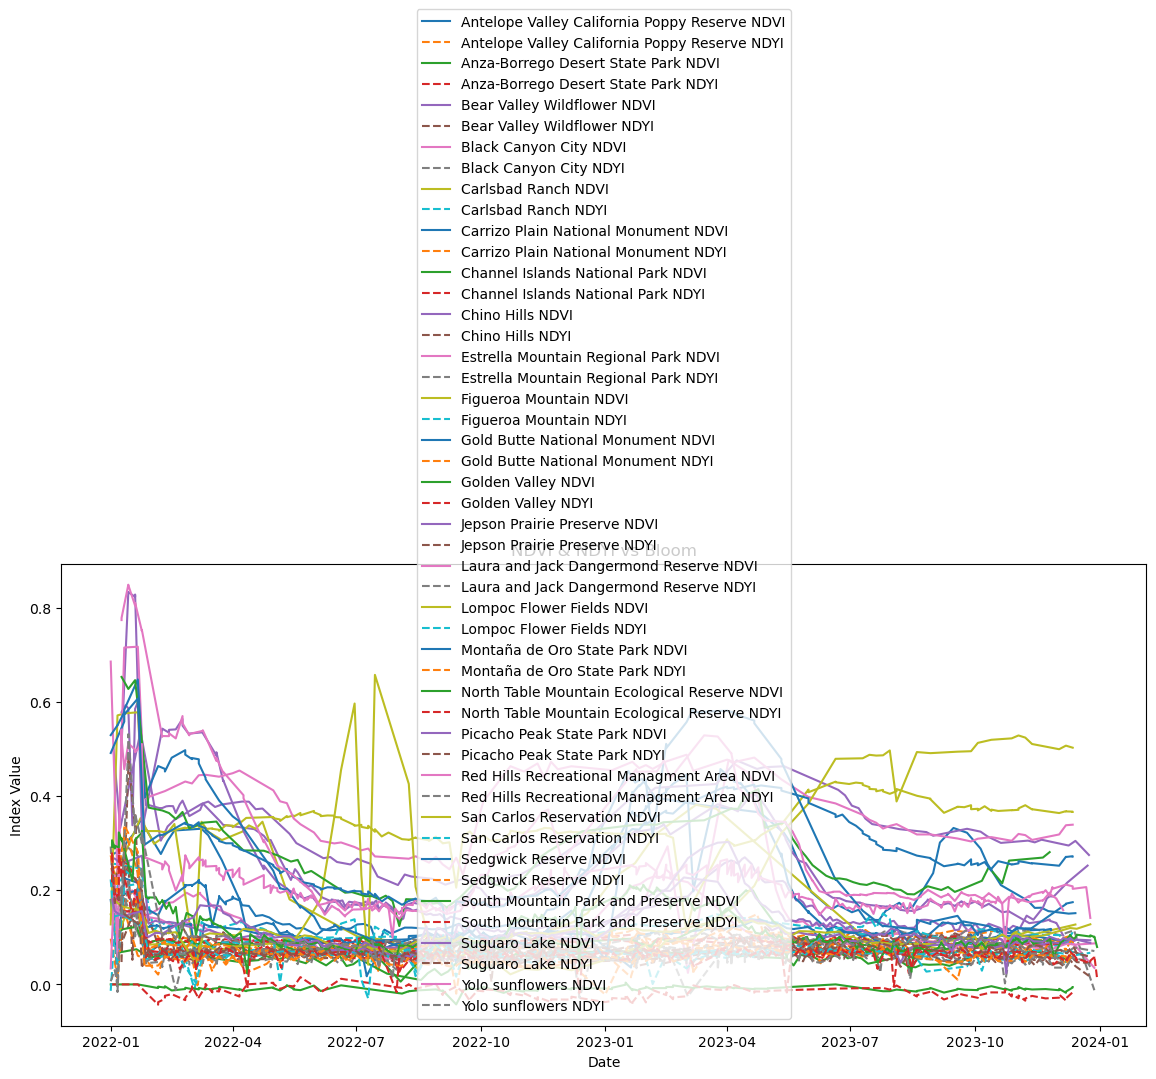

Map saved as map_final.html
Class distribution 'bloom' based on real observations:
bloom
1    2840
0     827
Name: count, dtype: int64
RandomForest predictions: [1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1

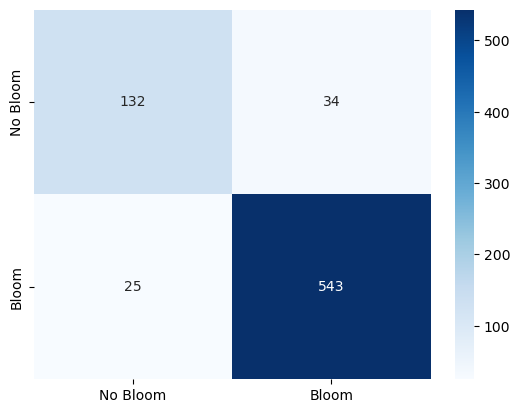

In [1]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
import requests
import numpy as np
import ruptures as rpt
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
import time

# --- Suppress warnings globally ---
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# --- 1️⃣ Connect to Google Earth Engine ---
ee.Authenticate()
ee.Initialize(project='ee-requestanastasiachernikova')  # replace with your Project ID

# --- 2️⃣ Load GeoJSON ---
gdf = gpd.read_file("WildflowerBlooms_AreaOfInterest.geojson")
if 'species' not in gdf.columns:
    gdf['species'] = gdf['Site'].fillna('Unknown_Species')

# --- 3️⃣ Function to fetch Pl@ntNet observations via GBIF ---
def fetch_gbif_plantnet(lat, lon, radius_km=100, years=range(2018, 2024), dataset_key='7a3679ef-5582-4aaa-81f0-8c2545cafc81'):
    all_dates = []

    def create_bbox(lat, lon, radius_km):
        delta_deg = radius_km / 111
        min_lat = lat - delta_deg
        max_lat = lat + delta_deg
        min_lon = lon - delta_deg
        max_lon = lon + delta_deg
        return f"POLYGON(({min_lon} {min_lat},{min_lon} {max_lat},{max_lon} {max_lat},{max_lon} {min_lat},{min_lon} {min_lat}))"

    geometry = create_bbox(lat, lon, radius_km)

    for year in years:
        offset = 0
        limit = 300
        while True:
            url = "https://api.gbif.org/v1/occurrence/search"
            params = {
                "datasetKey": dataset_key,
                "geometry": geometry,
                "year": year,
                "limit": limit,
                "offset": offset
            }

            retries = 5
            for attempt in range(retries):
                try:
                    resp = requests.get(url, params=params, timeout=20)
                    if resp.status_code == 429:
                        time.sleep((attempt + 1) * 5)
                        continue
                    resp.raise_for_status()
                    break
                except requests.RequestException as e:
                    if attempt < retries - 1:
                        time.sleep(5)
                        continue
                    print(f"❌ GBIF error for Pl@ntNet ({lat}, {lon}): {e}")
                    return []

            results = resp.json().get("results", [])
            if not results:
                break

            dates = [item['eventDate'] for item in results if item.get('eventDate')]
            all_dates.extend(dates)

            if len(results) < limit:
                break
            offset += limit
            time.sleep(1)

    return pd.to_datetime(pd.Series(all_dates), errors='coerce').dropna().to_list()

# --- 3️⃣ Function to fetch iNaturalist observation dates ---
def fetch_inaturalist_dates(lat, lon, radius_km=10, years=range(2022, 2024)):
    all_dates = []

    for year in years:
        page = 1
        while True:
            url = "https://api.inaturalist.org/v1/observations"
            params = {
                "lat": lat,
                "lng": lon,
                "radius": radius_km,
                "d1": f"{year}-01-01",
                "d2": f"{year}-12-31",
                "per_page": 200,
                "page": page,
                "term_id": 12,        # Plant Phenology
                "term_value_id": 13,  # Flowering
                "order": "desc",
                "order_by": "observed_on"
            }
            try:
                resp = requests.get(url, params=params, timeout=20)
                resp.raise_for_status()
                data = resp.json()
                results = data.get("results", [])
                if not results:
                    break

                dates = [item['observed_on_string'] for item in results if item.get('observed_on_string')]
                all_dates.extend(dates)

                if data['total_results'] <= page * 200:
                    break

                page += 1
                time.sleep(1)

            except requests.RequestException as e:
                print(f"❌ iNaturalist error for ({lat}, {lon}): {e}")
                break

    return pd.to_datetime(pd.Series(all_dates), errors='coerce').dropna().to_list()

# --- 4️⃣ Fetch NDVI/NDYI from Sentinel-2 ---
all_data = []
gbif_observation_dates = {}

for _, row in gdf.iterrows():
    centroid = row.geometry.centroid
    lon, lat = centroid.x, centroid.y
    species = row.get('species', 'Flower')

    plantnet_dates = fetch_gbif_plantnet(lat, lon, years=range(2022, 2024))
    inaturalist_dates = fetch_inaturalist_dates(lat, lon, years=range(2022, 2024))
    combined_dates = plantnet_dates + inaturalist_dates
    gbif_observation_dates[(lon, lat)] = combined_dates

    print(f"For point ({lon:.2f}, {lat:.2f}) found {len(plantnet_dates)} Pl@ntNet dates and {len(inaturalist_dates)} iNaturalist dates. Total: {len(combined_dates)}.")

    point = ee.Geometry.Point([lon, lat])
    buffer100 = point.buffer(100)

    s2 = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterDate("2022-01-01", "2023-12-31") \
        .filterBounds(point) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('system:time_start')

    def add_indices(img):
        ndvi = ee.Image(ee.Algorithms.If(
            img.bandNames().contains('B8'),
            img.normalizedDifference(['B8','B4']).rename('NDVI'),
            img.normalizedDifference(['SR_B5','SR_B4']).rename('NDVI')
        ))
        ndyi = ee.Image(ee.Algorithms.If(
            img.bandNames().contains('B3'),
            img.normalizedDifference(['B3','B2']).rename('NDYI'),
            img.normalizedDifference(['SR_B3','SR_B2']).rename('NDYI')
        ))
        return img.addBands([ndvi, ndyi])

    s2_indexed = s2.map(add_indices)

    def extract_indices(img):
        values = img.select(['NDVI','NDYI']).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=buffer100,
            scale=10
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            'ndvi': values.get('NDVI'),
            'ndyi': values.get('NDYI')
        })

    features = s2_indexed.map(extract_indices)

    try:
        features_info = features.getInfo()['features']
        for f in features_info:
            props = f['properties']
            if props['ndvi'] is not None and props['ndyi'] is not None:
                all_data.append({
                    'species': species,
                    'lon': lon,
                    'lat': lat,
                    'date': props['date'],
                    'ndvi': props['ndvi'],
                    'ndyi': props['ndyi']
                })
    except Exception as e:
        print(f"GEE error for point {lon}, {lat}: {e}")

df = pd.DataFrame(all_data)

if not df.empty:
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_year'] = df['date'].dt.dayofyear

    # --- 5️⃣ BFAST Break Detection ---
    def detect_breaks(series):
        if len(series) < 5:
            return []
        points = np.array(series)
        algo = rpt.Pelt(model="rbf").fit(points)
        result = algo.predict(pen=1)
        return result[:-1]

    df['bfast_breaks_ndvi'] = None
    df['bfast_breaks_ndyi'] = None

    for (species, lon, lat), group in df.groupby(['species','lon','lat']):
        ndvi_series = group.sort_values('date')['ndvi'].values
        ndyi_series = group.sort_values('date')['ndyi'].values

        breaks_ndvi = detect_breaks(ndvi_series)
        breaks_ndyi = detect_breaks(ndyi_series)

        df.loc[group.index, 'bfast_breaks_ndvi'] = pd.Series([breaks_ndvi]*len(group), index=group.index, dtype=object)
        df.loc[group.index, 'bfast_breaks_ndyi'] = pd.Series([breaks_ndyi]*len(group), index=group.index, dtype=object)

    # --- 6️⃣ Days since last break ---
    def days_since_last_break(date, breaks, all_dates):
        sorted_dates = sorted(all_dates)
        if not breaks:
            return -1
        break_dates = [sorted_dates[i] for i in breaks if i < len(sorted_dates)]
        past_breaks = [bd for bd in break_dates if bd <= date]
        if not past_breaks:
            return -1
        last_break_date = max(past_breaks)
        return (date - last_break_date).days

    df['days_since_ndvi_break'] = -1
    df['days_since_ndyi_break'] = -1

    for (species, lon, lat), group in df.groupby(['species','lon','lat']):
        all_dates_sorted = sorted(group['date'].tolist())
        breaks_ndvi = group['bfast_breaks_ndvi'].iloc[0]
        breaks_ndyi = group['bfast_breaks_ndyi'].iloc[0]

        df.loc[group.index, 'days_since_ndvi_break'] = group['date'].apply(
            lambda d: days_since_last_break(d, breaks_ndvi, all_dates_sorted)
        )
        df.loc[group.index, 'days_since_ndyi_break'] = group['date'].apply(
            lambda d: days_since_last_break(d, breaks_ndyi, all_dates_sorted)
        )

    # --- 7️⃣ NDVI/NDYI Visualization ---
    plt.figure(figsize=(14,6))
    for species, group in df.groupby('species'):
        plt.plot(group['date'], group['ndvi'], label=f"{species} NDVI")
        plt.plot(group['date'], group['ndyi'], linestyle='--', label=f"{species} NDYI")
    plt.xlabel("Date")
    plt.ylabel("Index Value")
    plt.title("NDVI & NDYI vs Bloom")
    plt.legend()
    plt.show()

    # --- 8️⃣ Map visualization ---
    m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=8)
    for _, row in gdf.iterrows():
        centroid = row.geometry.centroid
        folium.Marker([centroid.y, centroid.x], popup=row.get('species', 'Flower')).add_to(m)
    m.save("map_final.html")
    print("Map saved as map_final.html")

    # --- 9️⃣ RandomForest ---
    def assign_bloom_label(row, bloom_dates_dict, window_days=15):
        """
        Assigns bloom label = 1 if satellite date
        is within +/- window_days of actual observation date.
        """
        point_key = (row['lon'], row['lat'])
        observation_dates = bloom_dates_dict.get(point_key, [])
        if not observation_dates:
            return 0

        current_satellite_date = row['date'].tz_localize(None)  # make tz-naive

        for obs_date in observation_dates:
            obs_date_naive = pd.to_datetime(obs_date).tz_localize(None)  # also tz-naive
            time_difference = abs((current_satellite_date - obs_date_naive).days)
            if time_difference <= window_days:
                return 1
        return 0

    df['bloom'] = df.apply(
        assign_bloom_label,
        axis=1,
        bloom_dates_dict=gbif_observation_dates,
        window_days=15
    )

    print("Class distribution 'bloom' based on real observations:")
    print(df['bloom'].value_counts())

    # Prepare data for RandomForest
    features = ['ndvi', 'ndyi', 'day_of_year', 'days_since_ndvi_break', 'days_since_ndyi_break']
    X = df[features]
    y = df['bloom']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("RandomForest predictions:", y_pred)
    print("Model accuracy on test set:", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Bloom','Bloom'], yticklabels=['No Bloom','Bloom'])
    plt.show()

else:
    print("No NDVI/NDYI data available for points. Check your GeoJSON and Sentinel-2 filters.")